Energy Disaggregation using Neural Networks
=======================================

In [17]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GRU
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional, BatchNormalization, MaxPooling1D
from keras import regularizers, initializers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io

The following functions are used to extract the time and day information from a timestamp value.

In [18]:
def get_month(timevals):
    return dt.fromtimestamp(timevals).month
def get_week(timevals):
    return math.ceil(dt.fromtimestamp(timevals).day/7)
def get_hour(timevals):
    return dt.fromtimestamp(timevals).hour
def get_minute(timevals):
    return dt.fromtimestamp(timevals).minute
def get_second(timevals):
    return dt.fromtimestamp(timevals).second

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [19]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [20]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


Model Specification
-------------------------------
The following function is used to create the model.

The following function plots the losses against the epochs.

In [21]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

Data Preprocessing
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [6]:
def loadData(path, index, name):
    main11 = np.genfromtxt(path+'channel_1.dat', dtype = [int, float],)
    main12 = np.genfromtxt(path1+'channel_2.dat', dtype = [int, float])
    wash1 = np.genfromtxt(path1+'channel_'+index+'.dat', dtype = [int, float])
    maindf1 = pd.DataFrame(main11)
    maindf1.columns = ["timestamp", "mains1"]
    maindf2 = pd.DataFrame(main12)
    maindf2.columns = ["timestamp", "mains2"]
    washdf1 = pd.DataFrame(wash1)
    washdf1.columns = ["timestamp", name]
    traindf1 = maindf1.merge(maindf2, on = ('timestamp'))
    traindf1 = traindf1.merge(washdf1, how="inner", on = ('timestamp'))
    timevals = traindf1["timestamp"]
    traindf1["month"] = timevals.apply(get_month)
    traindf1["week"] = timevals.apply(get_week)
    traindf1["hour"] = timevals.apply(get_hour)
    traindf1["minute"] = timevals.apply(get_minute)
    traindf1["second"] = timevals.apply(get_second)
    mainR = scipy.io.loadmat("main_real.mat")
    mainI = scipy.io.loadmat("main_img.mat")
    main_real = mainR["main_real"]
    main_img = mainI["main_img"]
    #main_real = np.reshape(main_real,main_real.shape[0])
    #main_img = np.reshape(main_img,main_img.shape[0])
    y = traindf1[name].values
    
#     X = np.column_stack((traindf1["month"].values,traindf1["week"].values,
#                      traindf1["hour"].values,traindf1["minute"].values,
#                      traindf1["second"].values,main_real, main_img))
   
    return y

In [22]:
def create_seq(X):
    res = []
    for i in range(0,X.shape[0],1200):
        res.append(X[i:i+1200,:])
    res = np.array(res)
    return res
   

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

House 1:
-------------

In [8]:
path1 = ("low_freq/house_1/")
y = loadData(path1, "6", "dishwasher")

y = y.reshape(len(y), 1)

X = scipy.io.loadmat("features1.mat")
X = X["feature"]

start = random.randrange(0, X.shape[0]-27601)
X_train = X[start:start+24000,:]
y_train = y[start:start+24000,:]

#X_train,y_train = mini_batch(X,y,10000)
X_test = X[start+24001:start+27601,:]
y_test = y[start+24001:start+27601,:]

#X_test,y_test = mini_batch(X,y,1000)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [9]:
X_test.shape

(3600, 5)

Model Specification
-------------------------------
The following function is used to create the model.

In [10]:
def init_model():
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu", kernel_initializer="he_normal",
                    input_shape=(1200,5), padding="same", strides=1))
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))
   
    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                  stateful=False), merge_mode='concat'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    model.add(Dropout(0.25))
    model.compile(loss='mse', optimizer='adam')
    return model

W0817 00:00:15.890865  6832 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 00:00:15.904866  6832 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 00:00:15.907866  6832 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0817 00:00:15.923867  6832 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0817 00:00:15.929867  

Train on 20 samples, validate on 3 samples
Epoch 1/100
 - 19s - loss: 0.0543 - val_loss: 0.0987
Epoch 2/100
 - 17s - loss: 0.1489 - val_loss: 0.0614
Epoch 3/100
 - 18s - loss: 0.0873 - val_loss: 0.0248
Epoch 4/100
 - 19s - loss: 0.0512 - val_loss: 0.0270
Epoch 5/100
 - 19s - loss: 0.0553 - val_loss: 0.0241
Epoch 6/100
 - 17s - loss: 0.0502 - val_loss: 0.0277
Epoch 7/100
 - 20s - loss: 0.0523 - val_loss: 0.0257
Epoch 8/100
 - 19s - loss: 0.0484 - val_loss: 0.0248
Epoch 9/100
 - 20s - loss: 0.0470 - val_loss: 0.0252
Epoch 10/100
 - 20s - loss: 0.0469 - val_loss: 0.0245
Epoch 11/100
 - 20s - loss: 0.0461 - val_loss: 0.0245
Epoch 12/100
 - 20s - loss: 0.0463 - val_loss: 0.0249
Epoch 13/100
 - 21s - loss: 0.0467 - val_loss: 0.0244
Epoch 14/100
 - 21s - loss: 0.0464 - val_loss: 0.0242
Epoch 15/100
 - 21s - loss: 0.0455 - val_loss: 0.0244
Epoch 16/100
 - 19s - loss: 0.0455 - val_loss: 0.0245
Epoch 17/100
 - 21s - loss: 0.0456 - val_loss: 0.0244
Epoch 18/100
 - 21s - loss: 0.0452 - val_loss: 0

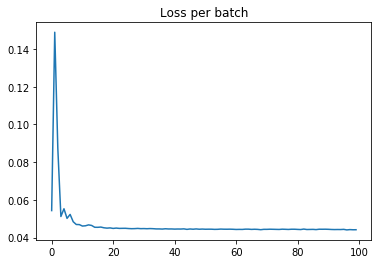

In [11]:
model = init_model()
history = LossHistory()
X_train = create_seq(X_train)
y_train = create_seq(y_train)
X_test = create_seq(X_test)
y_test = create_seq(y_test)
model.fit(X_train, y_train, epochs=100, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)

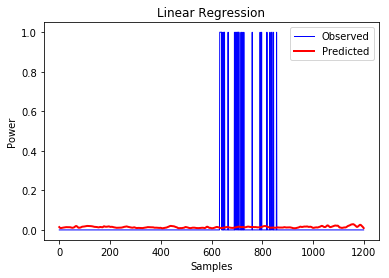

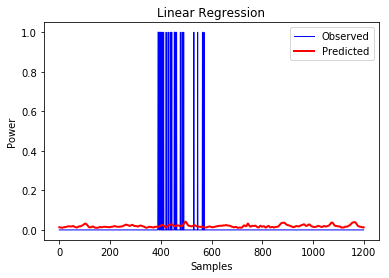

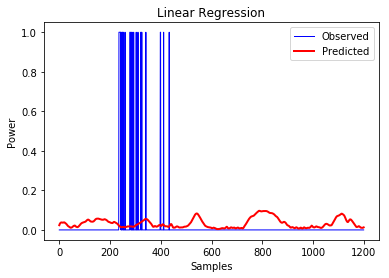

In [12]:
for i in range(len(y_test)):
    samples = range(len(y_test[i]))
    plt.plot(samples,y_test[i], color='blue', linewidth=1, label = 'Observed') 
    plt.plot(samples,y_pred[i], color='red', linewidth=2, label = 'Predicted') 
    plt.title('Linear Regression')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Power')
    plt.show()

=================================== X ===================================
-----------

House 2: 
-------------    

Data Preprocessing
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [23]:
def loadData(path, index, name):
    main11 = np.genfromtxt(path+'channel_1.dat', dtype = [int, float],)
    main12 = np.genfromtxt(path1+'channel_2.dat', dtype = [int, float])
    wash1 = np.genfromtxt(path1+'channel_'+index+'.dat', dtype = [int, float])
    maindf1 = pd.DataFrame(main11)
    maindf1.columns = ["timestamp", "mains1"]
    maindf2 = pd.DataFrame(main12)
    maindf2.columns = ["timestamp", "mains2"]
    washdf1 = pd.DataFrame(wash1)
    washdf1.columns = ["timestamp", name]
    traindf1 = maindf1.merge(maindf2, on = ('timestamp'))
    traindf1 = traindf1.merge(washdf1, how="inner", on = ('timestamp'))
    timevals = traindf1["timestamp"]
    traindf1["month"] = timevals.apply(get_month)
    traindf1["week"] = timevals.apply(get_week)
    traindf1["hour"] = timevals.apply(get_hour)
    traindf1["minute"] = timevals.apply(get_minute)
    traindf1["second"] = timevals.apply(get_second)
   
    #main_real = np.reshape(main_real,main_real.shape[0])
    #main_img = np.reshape(main_img,main_img.shape[0])
    y = traindf1[name].values
    
    X = np.column_stack((traindf1["month"].values,traindf1["week"].values,
                     traindf1["hour"].values,traindf1["minute"].values,
                     traindf1["second"].values,traindf1["mains1"].values,
                     traindf1["mains2"].values))
   
    return X,y

In [25]:
path2 = ("low_freq/house_2/")
y2 = loadData(path2, "10", "dishwasher")
y2 = y2.reshape(len(y2), 1)

X2 = scipy.io.loadmat("features2.mat")
X2 = X2['feature']

start = random.randrange(0, X.shape[0]-27601)
X_train = X2[start:start+24000,:]
y_train = y2[start:start+24000,:]

#X_train,y_train = mini_batch(X,y,10000)
X_test = X2[start+24001:start+27601,:]
y_test = y2[start+24001:start+27601,:]

#X_test,y_test = mini_batch(X,y,1000)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


AttributeError: 'tuple' object has no attribute 'reshape'

Model Specification
-------------------------------
The following function is used to create the model.

In [ ]:
def init_model():
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu", kernel_initializer="he_normal",
                    input_shape=(1200,7), padding="same", strides=1))
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))
   
    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                  stateful=False), merge_mode='concat'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    model.add(Dropout(0.25))
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
model = init_model()
history = LossHistory()
X_train = create_seq(X_train)
y_train = create_seq(y_train)
X_test = create_seq(X_test)
y_test = create_seq(y_test)
model.fit(X_train, y_train, epochs=100, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)

In [ ]:
for i in range(len(y_test)):
    samples = range(len(y_test[i]))
    plt.plot(samples,y_test[i], color='blue', linewidth=1, label = 'Observed') 
    plt.plot(samples,y_pred[i], color='red', linewidth=2, label = 'Predicted') 
    plt.title('Linear Regression')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Power')
    plt.show()

================================ X ================================
------

In [24]:
mainR = scipy.io.loadmat('main_real.mat')
mainI = scipy.io.loadmat('main_img.mat')
main_real = mainR['main_real']
main_img = mainI['main_img']

In [25]:
main_img.shape

(406748, 1)

In [9]:
path1 = ("low_freq/house_2/")
X, y = loadData(path1, "10", "dishwasher")
mainR = scipy.io.loadmat("main_real.mat")
mainI = scipy.io.loadmat("main_img.mat")
main_real = mainR["main_real"]
main_img = mainI["main_img"]

In [10]:
X.shape

(316840, 5)